In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loandataset/test_loan.csv
/kaggle/input/loandataset/train_loan.csv


In [2]:
# Install pyspark version 3.2
!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 7.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805894 sha256=c352b94175f7da6b878e31e97a6dfb99eb07181ed2283c7dccd5a0bd7b6a37cc
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
# Import the `SparkSession` class from PySpark to create and manage a Spark session.
# Initialize a new Spark session with the following configuration:
# `master("local[4]")`: Specifies a local Spark instance utilizing 4 CPU cores for parallel processing.
# `appName("MLib")`: Names the application "MLib" for easier identification in Spark monitoring tools.
# The `SparkSession` acts as the entry point for interacting with the Spark cluster and managing resources.

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[4]").appName("MLib").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/27 12:41:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load the dataset `train_loan.csv` into a Spark DataFrame using the `read.csv` method:
# `"/kaggle/input/loandataset/train_loan.csv"` specifies the file path to the dataset.
# `header=True` indicates that the first row contains column headers.
# `inferSchema=True` enables Spark to automatically infer the data types of the columns.
# Display the first few rows of the loaded DataFrame using the `show()` method to inspect the dataset.

ds = spark.read.csv("/kaggle/input/loandataset/train_loan.csv", header = True, inferSchema = True)
ds.show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [5]:
# Checking for missing values in the dataset
from pyspark.sql.functions import count,col,when
ds_null_values = ds.select([count(when( col(c).isNull(), c)).alias(c) for c in ds.columns])
ds_null_values.show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|    13|      3|        15|        0|           32|              0|                0|        22|              14|            50|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [6]:
# Replace missing values (nulls) in categorical columns with the value "Unknown":
# "Gender", "Married", "Dependents", and "Self_Employed" are filled with "Unknown".
# This strategy ensures that missing values are treated as a separate category,
# preserving the data structure and avoiding the loss of potentially valuable information during analysis.

from pyspark.sql import functions as F 
ds = ds.fillna({"Gender":"Unknown", "Married":"Unknown", "Dependents":"Unknown", "Self_Employed":"Unknown"})

# Calculate the approximate median values for the "LoanAmount", "Loan_Amount_Term", and "Credit_History" columns
# using PySpark's `approxQuantile` method. 
# The method efficiently estimates the median (50th percentile) with a relative error of up to 0.25.

# Replace missing values (nulls) in the specified columns with their respective median values:
# "LoanAmount" is filled with `LoanAmount_median`.
# "Loan_Amount_Term" is filled with `Loan_Amount_Term_median`.
# "Credit_History" is filled with `Credit_History_median`.

LoanAmount_median = ds.approxQuantile("LoanAmount", [0.5], 0.25)[0]
Loan_Amount_Term_median = ds.approxQuantile("Loan_Amount_Term", [0.5], 0.25)[0]
Credit_History_median = ds.approxQuantile("Credit_History", [0.5], 0.25)[0]

ds = ds.na.fill({"LoanAmount": LoanAmount_median})
ds = ds.na.fill({"Loan_Amount_Term": Loan_Amount_Term_median})
ds = ds.na.fill({"Credit_History":Credit_History_median})

In [7]:
# Create a DataFrame to count the number of missing (null) values in each column of `ds`:
# `col(c).isNull()`: Checks for null values in each column `c`.
# `when(col(c).isNull(), c)`: Returns the column name `c` if the value is null.
# `count()`: Counts the occurrences of null values for each column.
# `alias(c)`: Assigns the column name as the alias for the resulting count.
# The `select` method creates a new DataFrame containing the null value counts for each column.
# Use `show()` to display the null value counts, providing insight into which columns require further cleaning or imputation.

ds_null_values_corrected = ds.select([count(when( col(c).isNull(), c)).alias(c) for c in ds.columns])
ds_null_values_corrected.show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|     0|      0|         0|        0|            0|              0|                0|         0|               0|             0|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [8]:
# Import `StringIndexer` from PySpark's ML library to encode categorical columns as numerical indices.
# Define the list of categorical columns to be indexed:
# Columns like "Gender", "Married", "Education", "Self_Employed", "Property_Area", "Dependents", and "Loan_Status"
#   will be transformed into numerical representations.

# Iterate through each column in the `categorical_columns` list:
# For each column `c`, create a `StringIndexer` instance with:
# `inputCol=c`: The original categorical column.
# `outputCol=c + "_index"`: The new column that stores the indexed values.

# Fit the indexer to the dataset and transform `ds`, adding the indexed column to the DataFrame.

# Use `show()` to display the updated DataFrame, which now includes the new indexed columns.

from pyspark.ml.feature import StringIndexer
categorical_columns = ["Gender", "Married", "Education", "Self_Employed", "Property_Area","Dependents","Loan_Status"]
for c in categorical_columns:
    indexer = StringIndexer(inputCol= c , outputCol= c + "_index") 
    ds= indexer.fit(ds).transform(ds)
ds.show() 

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+------------+-------------+---------------+-------------------+-------------------+----------------+-----------------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|Gender_index|Married_index|Education_index|Self_Employed_index|Property_Area_index|Dependents_index|Loan_Status_index|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+------------+-------------+---------------+-------------------+-------------------+----------------+-----------------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|       100|             360|             1|     

In [9]:
# Define the list of columns to be removed from the DataFrame:
# - "Gender", "Married", "Education", "Self_Employed", "Property_Area", "Dependents", and "Loan_Status"
#   are removed as their encoded versions (with "_index") now exist in the DataFrame.

# Use the `drop()` method with unpacking (`*columns_to_delete`) to remove the specified columns.

# Display the updated DataFrame using `show()` to confirm the removal of the original categorical columns.
 
columns_to_delete = ["Gender", "Married", "Education", "Self_Employed", "Property_Area","Dependents","Loan_Status"]
ds = ds.drop(*columns_to_delete)
ds.show()

+--------+---------------+-----------------+----------+----------------+--------------+------------+-------------+---------------+-------------------+-------------------+----------------+-----------------+
| Loan_ID|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Gender_index|Married_index|Education_index|Self_Employed_index|Property_Area_index|Dependents_index|Loan_Status_index|
+--------+---------------+-----------------+----------+----------------+--------------+------------+-------------+---------------+-------------------+-------------------+----------------+-----------------+
|LP001002|           5849|              0.0|       100|             360|             1|         0.0|          1.0|            0.0|                0.0|                1.0|             0.0|              0.0|
|LP001003|           4583|           1508.0|       128|             360|             1|         0.0|          0.0|            0.0|                0.0|                2.0|      

In [10]:
# Convert the PySpark DataFrame `ds` to a Pandas DataFrame for easier manipulation and analysis.
# Define a function `detect_outliers` to identify outliers in a specified column using the Interquartile Range (IQR) method:
# Calculate the first quartile (Q1) and the third quartile (Q3) for the column.
# Compute the IQR as the difference between Q3 and Q1.
# Determine the lower and upper bounds as Q1 - 1.5 * IQR and Q3 + 1.5 * IQR, respectively.
# Filter and return rows where column values fall outside these bounds as outliers.

ds_pandas = ds.toPandas()
def detect_outliers(df, column):
 Q1 = df[column].quantile(0.25)
 Q3 = df[column].quantile(0.75)
 IQR = Q3 - Q1
 lower_bound = Q1 - 1.5 * IQR
 upper_bound = Q3 + 1.5 * IQR
 outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
 return outliers
    
# Find outliers in ApplicantIncome, CoapplicantIncome, LoanAmount and Loan_Amount_Term 

outliers_ApplicantIncome = detect_outliers(ds_pandas, 'ApplicantIncome')
outliers_CoapplicantIncome = detect_outliers(ds_pandas, 'CoapplicantIncome')
outliers_LoanAmount = detect_outliers(ds_pandas, 'LoanAmount')
outliers_Loan_Amount_Term = detect_outliers(ds_pandas, 'Loan_Amount_Term')

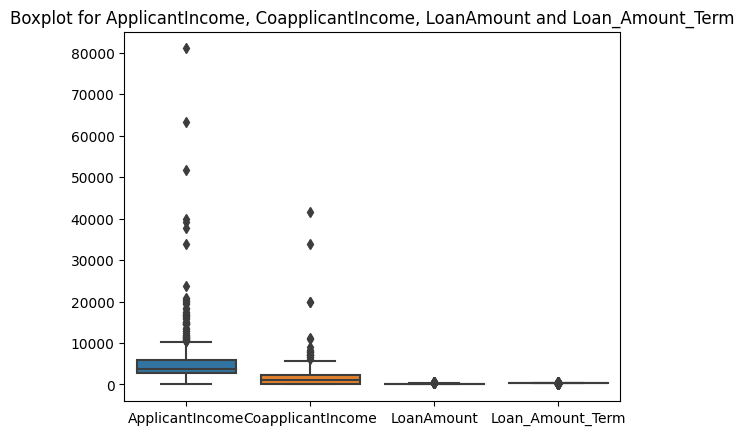

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# Box plot for ApplicantIncome, CoapplicantIncome,LoanAmount and Loan_Amount_Term
sns.boxplot(data=ds_pandas[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount' , 'Loan_Amount_Term']])
plt.title('Boxplot for ApplicantIncome, CoapplicantIncome, LoanAmount and Loan_Amount_Term')
plt.show()


In [12]:
# Apply logarithmic transformation to selected numerical columns to reduce skewness and normalize the distribution.
# A small constant (1) is added to avoid issues with zero values before applying the logarithm.
# "ApplicantIncome", "CoapplicantIncome", and "LoanAmount" columns are transformed to handle large variations.
# "Loan_Amount_Term" is also transformed to improve the distribution for further analysis or modeling.

ds_pandas["ApplicantIncome"] = np.log(ds_pandas["ApplicantIncome"] + 1 )
ds_pandas["CoapplicantIncome"] = np.log(ds_pandas["CoapplicantIncome"] + 1 )
ds_pandas["LoanAmount"] = np.log(ds_pandas["LoanAmount"] + 1 )
ds_pandas["Loan_Amount_Term"] = np.log(ds_pandas["Loan_Amount_Term"] + 1 )

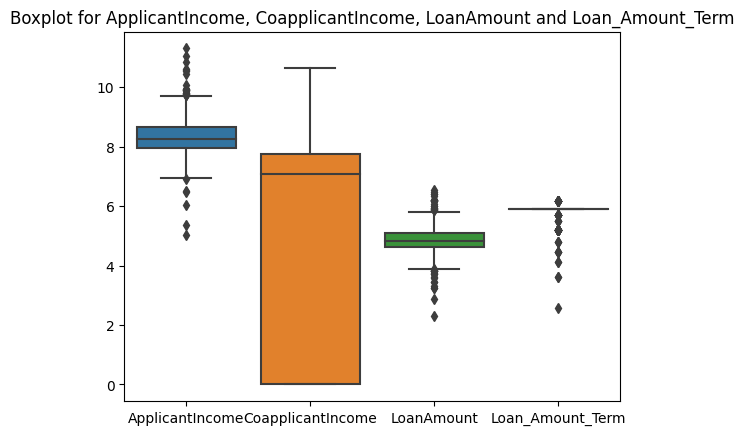

In [13]:
# Create a boxplot using Seaborn to visualize the distribution and detect potential outliers
# for the specified numerical columns in the Pandas DataFrame `ds_pandas`.

# Pass the subset of columns to be visualized:
# - "ApplicantIncome", "CoapplicantIncome", "LoanAmount", and "Loan_Amount_Term".

# Add a title to the plot for context.

# Use `plt.show()` to render the plot.
# The boxplot will display the median, interquartile range (IQR), and potential outliers for each column.

sns.boxplot(data=ds_pandas[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount' , 'Loan_Amount_Term']])
plt.title('Boxplot for ApplicantIncome, CoapplicantIncome, LoanAmount and Loan_Amount_Term')
plt.show()

In [14]:
# Convert the data types of specific columns in the Pandas DataFrame `ds_pandas`:
# - "Loan_ID" is converted to `str` to ensure it is treated as a string identifier.
# - "ApplicantIncome" is converted to `int` for numerical consistency as an integer.
# - "CoapplicantIncome" is converted to `float` to handle potential decimal values.
# - "LoanAmount" is converted to `int` for numerical representation as whole numbers.
# - "Loan_Amount_Term" is converted to `int` for consistent integer representation.
# - "Credit_History" is converted to `int` to ensure uniform handling of credit history categories.

# This ensures the data types are appropriately formatted for further processing and analysis.

ds_pandas["Loan_ID"] = ds_pandas["Loan_ID"].astype(str)
ds_pandas["ApplicantIncome"] = ds_pandas["ApplicantIncome"].astype(int)
ds_pandas["CoapplicantIncome"] = ds_pandas["CoapplicantIncome"].astype(float)
ds_pandas["LoanAmount"] = ds_pandas["LoanAmount"].astype(int)
ds_pandas["Loan_Amount_Term"] = ds_pandas["Loan_Amount_Term"].astype(int)
ds_pandas["Credit_History"] = ds_pandas["Credit_History"].astype(int)

In [15]:
# Convert the Pandas DataFrame to a list of row dictionaries
data_records = ds_pandas.to_dict(orient='records')
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

schema = StructType([
    StructField("Loan_ID", StringType(), True),
    StructField("ApplicantIncome", IntegerType(), True),
    StructField("CoapplicantIncome", FloatType(), True),
    StructField("LoanAmount", IntegerType(), True),
    StructField("Loan_Amount_Term", IntegerType(), True),
    StructField("Credit_History", IntegerType(), True),
    StructField("Gender_index", FloatType(), True),
    StructField("Married_index", FloatType(), True),
    StructField("Education_index", FloatType(), True),
    StructField("Self_Employed_index", FloatType(), True),
    StructField("Property_Area_index", FloatType(), True),
    StructField("Dependents_index", FloatType(), True),
    StructField("Loan_Status_index", FloatType(), True)
])
# Create Spark DataFrame from list of dictionaries with schema
ds = spark.createDataFrame(data_records, schema=schema)
ds.show()

+--------+---------------+-----------------+----------+----------------+--------------+------------+-------------+---------------+-------------------+-------------------+----------------+-----------------+
| Loan_ID|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Gender_index|Married_index|Education_index|Self_Employed_index|Property_Area_index|Dependents_index|Loan_Status_index|
+--------+---------------+-----------------+----------+----------------+--------------+------------+-------------+---------------+-------------------+-------------------+----------------+-----------------+
|LP001002|              8|              0.0|         4|               5|             1|         0.0|          1.0|            0.0|                0.0|                1.0|             0.0|              0.0|
|LP001003|              8|        7.3192024|         4|               5|             1|         0.0|          0.0|            0.0|                0.0|                2.0|      

In [16]:
# Import `VectorAssembler` and `MinMaxScaler` from PySpark ML for feature engineering and scaling.

# Step 1: Label Encoding
# - Create a `StringIndexer` to convert the "Loan_Status_index" column into a numerical label.
# - `inputCol="Loan_Status_index"` specifies the input column.
# - `outputCol="label"` specifies the target column for storing the encoded labels.

# Step 2: Feature Vectorization
# - Use `VectorAssembler` to combine multiple feature columns into a single vector column.
# - `inputCols` includes numerical and categorical features that are important for modeling:
#   - "Dependents_index", "ApplicantIncome", "CoapplicantIncome", "LoanAmount",
#     "Loan_Amount_Term", "Credit_History", "Gender_index", "Married_index",
#     "Education_index", "Self_Employed_index", "Property_Area_index".
# - `outputCol="features"` creates a new column to store the assembled feature vectors.

# Step 3: Feature Scaling
# - Use `MinMaxScaler` to normalize the feature vectors in the "features" column.
# - `inputCol="features"` specifies the column to scale.
# - `outputCol="scaledFeatures"` creates a new column with scaled values in the range [0, 1].

# This pipeline prepares the dataset for machine learning by encoding labels, combining features, and scaling them for better model performance.

from pyspark.ml.feature import  VectorAssembler, MinMaxScaler
label_indexer = StringIndexer (inputCol= "Loan_Status_index", outputCol= "label")
assembler = VectorAssembler(inputCols= ["Dependents_index","ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term","Credit_History","Gender_index","Married_index","Education_index","Self_Employed_index","Property_Area_index"], outputCol= "features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")


In [17]:
# Import the `Pipeline` class from PySpark ML to automate the sequence of data preprocessing steps.

# Step 1: Define the pipeline stages:
# - `label_indexer`: Converts "Loan_Status_index" to a numerical label stored in the "label" column.
# - `assembler`: Combines feature columns into a single vector in the "features" column.
# - `scaler`: Normalizes the "features" column to the range [0, 1], outputting to "scaledFeatures".

# Step 2: Initialize a `Pipeline` with the defined stages:
# - The `Pipeline` ensures the stages are executed in sequence.

# Step 3: Fit the pipeline to the dataset `ds`:
# - `fit()` trains the pipeline components using the data, such as determining scaling parameters.

# Step 4: Apply the pipeline transformations:
# - `transform()` processes the dataset, producing the transformed DataFrame `ds_training_cleansed`.
# - The resulting DataFrame includes columns like "label", "features", and "scaledFeatures", ready for model training.

# This approach streamlines preprocessing, ensuring all steps are executed consistently and reproducibly.

from pyspark.ml import Pipeline
ds_stages = Pipeline(stages=[label_indexer,assembler,scaler])
ds_fit = ds_stages.fit(ds)
ds_training_cleansed = ds_fit.transform(ds)

In [18]:
# Define a list of columns to be dropped from the DataFrame:
# - The columns "Dependents_index", "ApplicantIncome", "CoapplicantIncome", "LoanAmount",
#   "Loan_Amount_Term", "Credit_History", "Loan_Status", "Gender_index", "Married_index",
#   "Education_index", "Self_Employed_index", and "Property_Area_index" are removed as they are now 
#   represented in the "features" or "label" columns.

# Use the `drop()` method with unpacking (`*columns_to_drop`) to remove the specified columns from the DataFrame.

# Display the resulting DataFrame `ds_training_cleansed` using `show()` to confirm the removal of the columns.
# The remaining columns are expected to include "features", "scaledFeatures", and "label", ready for modeling.

columns_to_drop = ["Dependents_index","ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term","Credit_History","Loan_Status","Gender_index","Married_index","Education_index","Self_Employed_index","Property_Area_index"]
ds_training_cleansed = ds_training_cleansed.drop(*columns_to_drop)
ds_training_cleansed.show()

+--------+-----------------+-----+--------------------+--------------------+
| Loan_ID|Loan_Status_index|label|            features|      scaledFeatures|
+--------+-----------------+-----+--------------------+--------------------+
|LP001002|              0.0|  0.0|(11,[1,3,4,5,7,10...|(11,[1,3,4,5,7,10...|
|LP001003|              1.0|  1.0|[1.0,8.0,7.319202...|[0.25,0.5,0.68805...|
|LP001005|              0.0|  0.0|(11,[1,3,4,5,9,10...|(11,[1,3,4,5,9,10...|
|LP001006|              0.0|  0.0|[0.0,7.0,7.765993...|[0.0,0.3333333333...|
|LP001008|              0.0|  0.0|(11,[1,3,4,5,7,10...|(11,[1,3,4,5,7,10...|
|LP001011|              0.0|  0.0|[2.0,8.0,8.342124...|[0.5,0.5,0.784219...|
|LP001013|              0.0|  0.0|[0.0,7.0,7.324490...|[0.0,0.3333333333...|
|LP001014|              1.0|  1.0|(11,[0,1,2,3,4],[...|(11,[0,1,2,3,4],[...|
|LP001018|              0.0|  0.0|[2.0,8.0,7.331060...|[0.5,0.5,0.689172...|
|LP001020|              1.0|  1.0|(11,[0,1,2,3,4,5]...|(11,[0,1,2,3,4,5]...|

In [19]:
# Split the cleansed dataset into testing and training subsets:
# - `randomSplit([0.3, 0.7], seed=1234)` divides the data into:
#   - 30% for the testing set.
#   - 70% for the training set.
# - The `seed=1234` ensures reproducibility by controlling the randomness of the split.

# The resulting subsets `testing` and `training` are ready to be used for model evaluation and training, respectively.

(testing,training) = ds_training_cleansed.randomSplit([0.3,0.7],seed=1234)

In [20]:
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [21]:
# Import `DecisionTreeClassifier` from PySpark's ML library to create a decision tree model.

# Step 1: Initialize a `DecisionTreeClassifier` instance.
# - This model will be used to classify the data based on the "label" column (target variable).

# Step 2: Train the decision tree model on the `training` dataset.
# - `fit(training)` fits the model to the training data, learning from the "features" and "label" columns.

# Step 3: Apply the trained decision tree model to the `testing` dataset.
# - `transform(testing)` makes predictions on the test set, generating a new DataFrame with predicted labels and other related metrics (e.g., probabilities, raw prediction values).

# The `DT_transform` DataFrame will contain the predictions and be used for model evaluation.

DT = DecisionTreeClassifier()
DT_fit = DT.fit(training)
DT_transform = DT_fit.transform(testing)

In [22]:
# Import `MulticlassClassificationEvaluator` from PySpark ML for evaluating multi-class classification models.

# Step 1: Initialize an evaluator instance to assess the performance of the decision tree model.

# Step 2: Evaluate the model using different metrics:
# - `accuracy`: Measures the proportion of correctly predicted labels over total predictions.
# - `weightedPrecision`: Calculates precision considering class imbalance, weighted by the number of instances in each class.
# - `weightedRecall`: Computes recall, adjusted for class distribution.

# `evaluator.evaluate(DT_transform)` evaluates the decision tree's predictions on the test set `DT_transform`.
# The specific metric is selected by setting the `metricName` parameter.

# Step 3: Print the evaluation results:
# - The accuracy, precision, and recall values of the Decision Tree classifier are displayed.

# These metrics will help assess how well the model performs across different aspects, particularly for imbalanced data.

evaluator = MulticlassClassificationEvaluator()
DT_Accuracy = evaluator.evaluate(DT_transform,{evaluator.metricName:"accuracy"})
DT_Precision = evaluator.evaluate(DT_transform,{evaluator.metricName:"weightedPrecision"})
DT_Recall = evaluator.evaluate(DT_transform,{evaluator.metricName:"weightedRecall"})
print (f"Decision Tree Accuracy: {DT_Accuracy}, Decision Tree Precision: {DT_Precision}, Decision Tree Recall: {DT_Recall}" )

Decision Tree Accuracy: 0.7738095238095238, Decision Tree Precision: 0.7745412585838117, Decision Tree Recall: 0.7738095238095238


In [23]:
# Import `LogisticRegression` from PySpark's ML library to create a logistic regression model.

# Step 1: Initialize a `LogisticRegression` instance.
# - Logistic Regression is a classification algorithm used for predicting binary or multi-class outcomes.

# Step 2: Train the logistic regression model on the `training` dataset.
# - `fit(training)` fits the model to the training data, learning from the "features" and "label" columns.

# Step 3: Apply the trained logistic regression model to the `testing` dataset.
# - `transform(testing)` generates predictions on the test set and produces a new DataFrame with predicted labels and associated probabilities.

# The resulting DataFrame `LR_transform` contains the logistic regression predictions, which can be evaluated further.

LR = LogisticRegression()
LR_fit = LR.fit(training)
LR_transform = LR_fit.transform(testing)

In [24]:
# Evaluate the performance of the Logistic Regression model using the `MulticlassClassificationEvaluator`.

# Step 1: Evaluate the Logistic Regression model using the same metrics:
# - `accuracy`: Measures the proportion of correctly predicted labels.
# - `weightedPrecision`: Precision weighted by the class distribution, useful for imbalanced classes.
# - `weightedRecall`: Recall weighted by the class distribution, useful for imbalanced classes.

# `evaluator.evaluate(LR_transform)` evaluates the predictions made by the logistic regression model on the test set `LR_transform`.
# The metric to evaluate is selected by setting the `metricName` parameter.

# Step 2: Print the evaluation results for the logistic regression model:
# - Displays the accuracy, precision, and recall values, providing a comprehensive assessment of the model's performance.

# These metrics give a clear understanding of the logistic regression model's ability to make accurate, precise, and complete predictions, especially in scenarios where class imbalance exists.

LR_Accuracy = evaluator.evaluate(LR_transform,{evaluator.metricName:"accuracy"})
LR_Precision = evaluator.evaluate(LR_transform,{evaluator.metricName:"weightedPrecision"})
LR_Recall = evaluator.evaluate(LR_transform,{evaluator.metricName:"weightedRecall"})
print (f"Logistic Regression Accuracy: {LR_Accuracy}, Logistic Regression Precision: {LR_Precision}, Logistic Regression Recall: {LR_Recall}" )

Logistic Regression Accuracy: 0.7916666666666666, Logistic Regression Precision: 0.8165992112909921, Logistic Regression Recall: 0.7916666666666667


In [25]:
# Import `MulticlassMetrics` from PySpark's MLLib to evaluate multi-class classification models using various metrics.

# Step 1: Convert the predictions from the `DT_transform` DataFrame into an RDD of (label, prediction) pairs.
# - `select("label", "prediction")`: Selects the true labels and predicted labels.
# - `.rdd`: Converts the DataFrame into an RDD to use the `MulticlassMetrics` class.

# Step 2: Initialize `MulticlassMetrics` with the RDD to calculate classification metrics.
# - `DT_MCM = MulticlassMetrics(DT_transform_rdd)`: Creates a `MulticlassMetrics` instance that calculates various evaluation metrics for the decision tree model.

# Step 3: Get the confusion matrix from the `MulticlassMetrics` object.
# - `DT_MCM.confusionMatrix()`: Returns the confusion matrix as a dense matrix.
# - `.toArray()`: Converts the confusion matrix into a NumPy array for easier readability.

# Step 4: Print the confusion matrix.
# - The confusion matrix provides insights into the true positive, false positive, true negative, and false negative predictions made by the decision tree model.

# This matrix will help evaluate the model's performance in terms of class misclassifications.

from pyspark.mllib.evaluation import MulticlassMetrics
DT_transform_rdd = DT_transform.select("label","prediction").rdd
DT_MCM= MulticlassMetrics(DT_transform_rdd)
DT_CM = DT_MCM.confusionMatrix().toArray()
print("Confusion Matrix for DT:")
print(DT_CM)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix for DT:
[[109.  32.]
 [  6.  21.]]


In [26]:
# Convert the predictions from the `LR_transform` DataFrame into an RDD of (label, prediction) pairs.
# - `select("label", "prediction")`: Extracts the true labels and predicted labels from the DataFrame.
# - `.rdd`: Converts the DataFrame into an RDD to use with `MulticlassMetrics`.

# Initialize the `MulticlassMetrics` object with the RDD to evaluate the logistic regression model.
# - `LR_MCM = MulticlassMetrics(LR_transform_rdd)`: Creates a `MulticlassMetrics` instance that computes various classification metrics for logistic regression.

# Get the confusion matrix from the `MulticlassMetrics` object.
# - `LR_MCM.confusionMatrix()`: Returns the confusion matrix, which shows the distribution of true positives, false positives, true negatives, and false negatives.
# - `.toArray()`: Converts the confusion matrix into a NumPy array for easier interpretation.

# Print the confusion matrix to evaluate the logistic regression model's performance.
# - The confusion matrix will provide insights into the misclassification patterns and help assess the model's accuracy in each class.

# The confusion matrix is a useful tool to visualize where the logistic regression model is making errors.

LR_transform_rdd = LR_transform.select("label","prediction").rdd
LR_MCM= MulticlassMetrics(LR_transform_rdd)
LR_CM = LR_MCM.confusionMatrix().toArray()
print("Confusion Matrix for LR:")
print(LR_CM)

Confusion Matrix for LR:
[[113.  33.]
 [  2.  20.]]


In [27]:
# Import necessary libraries:
# - `pandas`: For creating and manipulating DataFrames.
# - `matplotlib.pyplot` and `seaborn`: For plotting and visualizing data.

# Step 1: Convert the confusion matrix of the Decision Tree (DT) model into a Pandas DataFrame.
# - `DT_CM` is the confusion matrix for the decision tree model, which is a NumPy array.
# - The `DataFrame` is created with `index=["label", "prediction"]` and `columns=["label", "prediction"]` to label the rows and columns for clarity.

# Step 2: Convert the confusion matrix of the Logistic Regression (LR) model into a Pandas DataFrame.
# - `LR_CM` is the confusion matrix for the logistic regression model, also a NumPy array.
# - Similar to the decision tree, a `DataFrame` is created with labeled rows and columns.

# These `DataFrame` objects, `DT_pandas` and `LR_pandas`, make it easier to visualize and compare the confusion matrices of both models.

# This is the preparation for visualizing the confusion matrices using heatmaps or other plotting techniques.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DT_pandas = pd.DataFrame(DT_CM, index = ['Actual Positive', 'Actual Negative'], columns = ['Predicted Positive', 'Predicted Negative'])
LR_pandas = pd.DataFrame(LR_CM, index = ['Actual Positive', 'Actual Negative'], columns = ['Predicted Positive', 'Predicted Negative'])

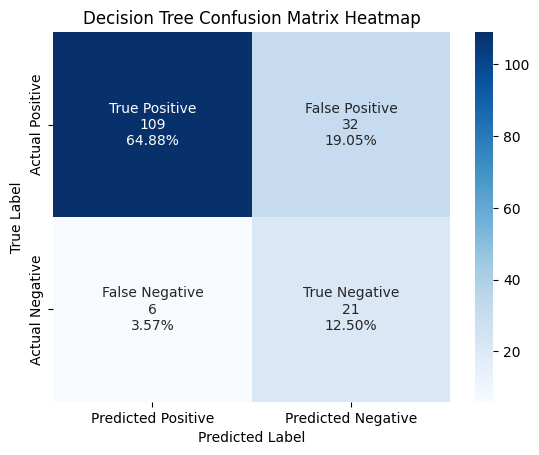

In [28]:
# Access the underlying NumPy array
data_values = DT_pandas.values  

# Create group counts and percentages
group_counts = ["{0:0.0f}".format(value) for value in data_values.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in data_values.flatten() / np.sum(data_values)]

# Define group names
group_names = ["True Positive", "False Positive", "False Negative", "True Negative"]

# Combine labels
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

# Reshape labels to a 2x2 array
labels = np.asarray(labels).reshape(2, 2)

# Create the heatmap
sns.heatmap(DT_pandas, annot=labels, fmt="", cmap='Blues')

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix Heatmap')

plt.show()

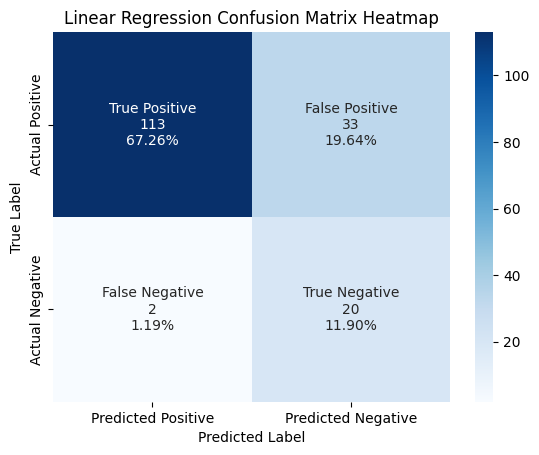

In [29]:
# Access the underlying NumPy array
data_values = LR_pandas.values  

# Create group counts and percentages
group_counts = ["{0:0.0f}".format(value) for value in data_values.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in data_values.flatten() / np.sum(data_values)]

# Define group names
group_names = ["True Positive", "False Positive", "False Negative", "True Negative"]

# Combine labels
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

# Reshape labels to a 2x2 array
labels = np.asarray(labels).reshape(2, 2)

# Create the heatmap
sns.heatmap(LR_pandas, annot=labels, fmt="", cmap='Blues')

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Linear Regression Confusion Matrix Heatmap')

plt.show()